In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from sklearn.metrics import *
import seaborn as sns
import statsmodels as sm
import statsmodels.tsa.api as smt
!pip install pmdarima
from pmdarima import auto_arima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 40.9 MB/s eta 0:00:00


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/badminton - badminton.csv.csv')
df = df.rename(columns={'startDate': 'date', 'sellerMetric.value': 'sales', 'platformMetric.value': 'total_sales'})
df['date'] = pd.to_datetime(df['date'], yearfirst=True)



In [ ]:
old_share_of_sales = df['sales'].mean()/df['total_sales'].mean()
df['outliers'] = df['sales'] < old_share_of_sales * df['total_sales'] * (2/3) ## Если True, то это выброс.
# df['sales_new'] = df[df['outliers'] == True]['total_sales']*0.06
df['sales_new']= df[df['outliers'] == True]['total_sales']*0.06
df['sales_new'][df['outliers'] == False] = df[df['outliers'] == False]['sales']


<ipython-input-3-3f8670b11776>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sales_new'][df['outliers'] == False] = df[df['outliers'] == False]['sales']


## Немного красоты


In [ ]:
df.head(200)

,date,sales,total_sales,outliers,sales_new
0,2022-07-30,13232.0,188721.0,False,13232.00
1,2022-07-31,6928.0,208330.0,False,6928.00
2,2022-08-01,10322.0,239983.0,False,10322.00
3,2022-08-02,8625.0,194862.0,False,8625.00
4,2022-08-03,8496.0,286282.0,False,8496.00
...,...,...,...,...,...
195,2023-02-10,0.0,42631.0,True,2557.86
196,2023-02-11,0.0,17940.0,True,1076.40
197,2023-02-12,0.0,33934.0,True,2036.04
198,2023-02-13,0.0,50794.0,True,3047.64


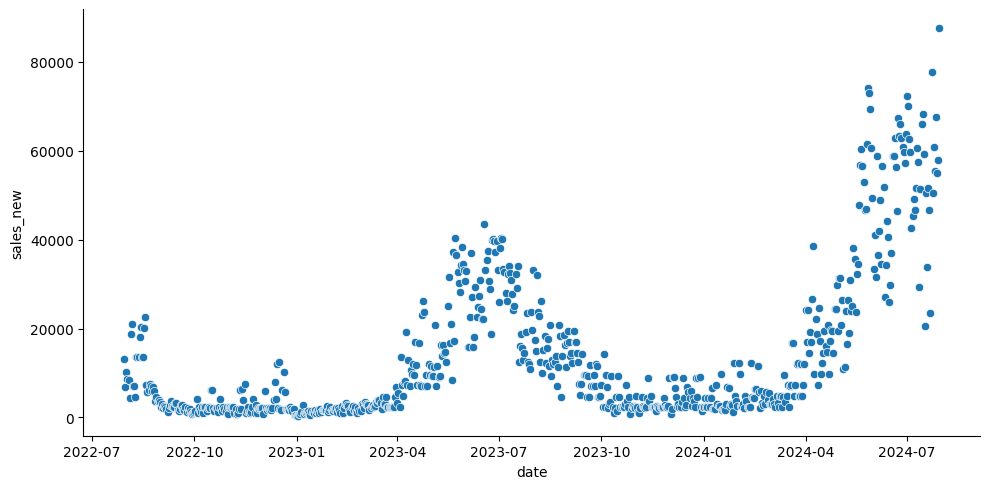

In [ ]:
sns.relplot(data=df, x='date', y='sales_new', aspect=2) ### График sales без нулей

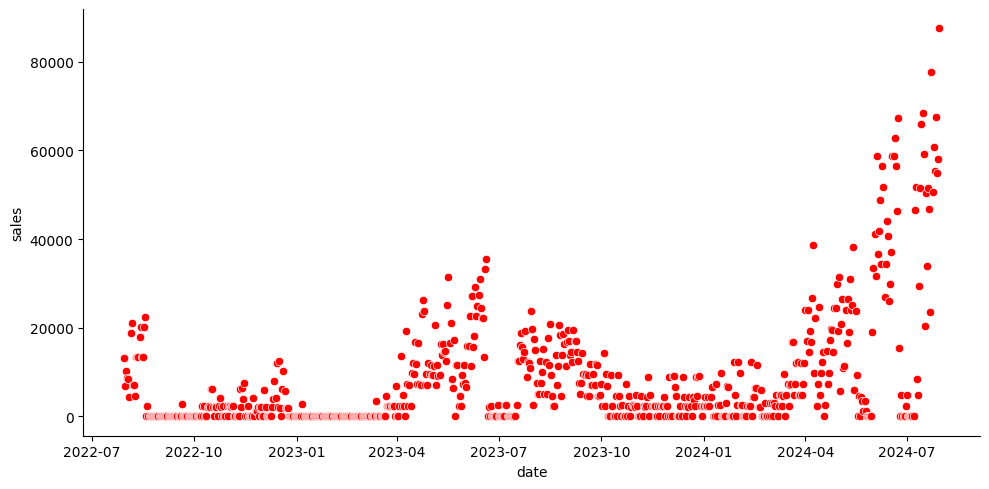

In [ ]:
sns.relplot(data=df, x='date', y='sales', aspect=2, color='red') # График с нулями.

## Код

In [ ]:
size = int(len(df) * 0.75)
df_train, df_test = df[:size], df[size:]
len(df), len(df_train), len(df_test)

(732, 549, 183)

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Предположим, что у вас есть датафрейм df_train с колонкой sales_new
# Логарифмирование данных
df_train['log_sales_new'] = np.log(df_train['sales_new'])

# Построение модели SARIMAX на логарифмированных данных
model = sm.tsa.statespace.SARIMAX(
    df_train['log_sales_new'],
    order=(4, 1, 1),
    seasonal_order=(0, 1, 0, 365)
).fit(disp=1)

# Прогнозирование
forecast_log = model.forecast(steps=10)  # Предполагаем, что нужно сделать прогноз на 10 шагов

# Обратное преобразование прогноза
forecast = np.exp(forecast_log)

# Вывод прогноза
print(forecast)

In [ ]:
df_train['log_sales_new'] = np.log(df_train['sales_new'])

<ipython-input-5-a317e788ce0e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['log_sales_new'] = np.log(df_train['sales_new'])


In [ ]:
# model = auto_arima(df_train['log_sales_new'][:], seasonal=True, m=365, trace=True,
#                    error_action='trace', suppress_warnings=True, d = 1, D= 1, start_q = 1, max_q = 2, start_p = 4, max_p = 12, start_P = 0, max_P = 2, start_Q = 0, max_Q = 2, information_criterion='aic',
#                    stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(4,1,1)(0,1,0)[365]             : AIC=415.430, Time=1059.64 sec


In [ ]:
best_model = sm.tsa.statespace.api.SARIMAX(df_train.log_sales_new, order=(4, 1, 1), \
                                        seasonal_order=(0, 1, 0, 365)).fit(disp=1)

In [ ]:
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                        log_sales_new   No. Observations:                  549
Model:             SARIMAX(4, 1, 1)x(0, 1, [], 365)   Log Likelihood                -201.715
Date:                              Thu, 29 Aug 2024   AIC                            415.430
Time:                                      15:15:40   BIC                            434.687
Sample:                                           0   HQIC                           423.236
                                              - 549                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2242      0.228     -0.982      0.326      -0.672       0.224
ar.L2         -0.27

In [ ]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return
def weighted_average_percentage_error(y_true, y_pred):
    # Вычисляем абсолютные ошибки
    absolute_errors = np.abs(y_true - y_pred)

    # Вычисляем сумму абсолютных ошибок
    sum_absolute_errors = np.sum(absolute_errors)

    # Вычисляем сумму абсолютных истинных значений
    sum_absolute_true = np.sum(np.abs(y_true))

    # Вычисляем WAPE
    wape = sum_absolute_errors / sum_absolute_true

    return wape

def root_mean_squared_logarithmic_error(y_true, y_pred):
    # Вычисляем логарифмы истинных и предсказанных значений, добавляя 1 для стабильности
    log_true = np.log1p(y_true)
    log_pred = np.log1p(y_pred)

    # Вычисляем квадраты разности логарифмов
    squared_log_diff = np.square(log_pred - log_true)

    # Вычисляем среднее значение квадратов разности
    mean_squared_log_diff = np.mean(squared_log_diff)

    ## Суммируем
    sum = np.sum(mean_squared_log_diff)

    # Вычисляем корень из среднего значения квадратов разности
    rmsle = np.sqrt(sum)

    return rmsle

Критерий Дики-Фуллера: p=0.000000


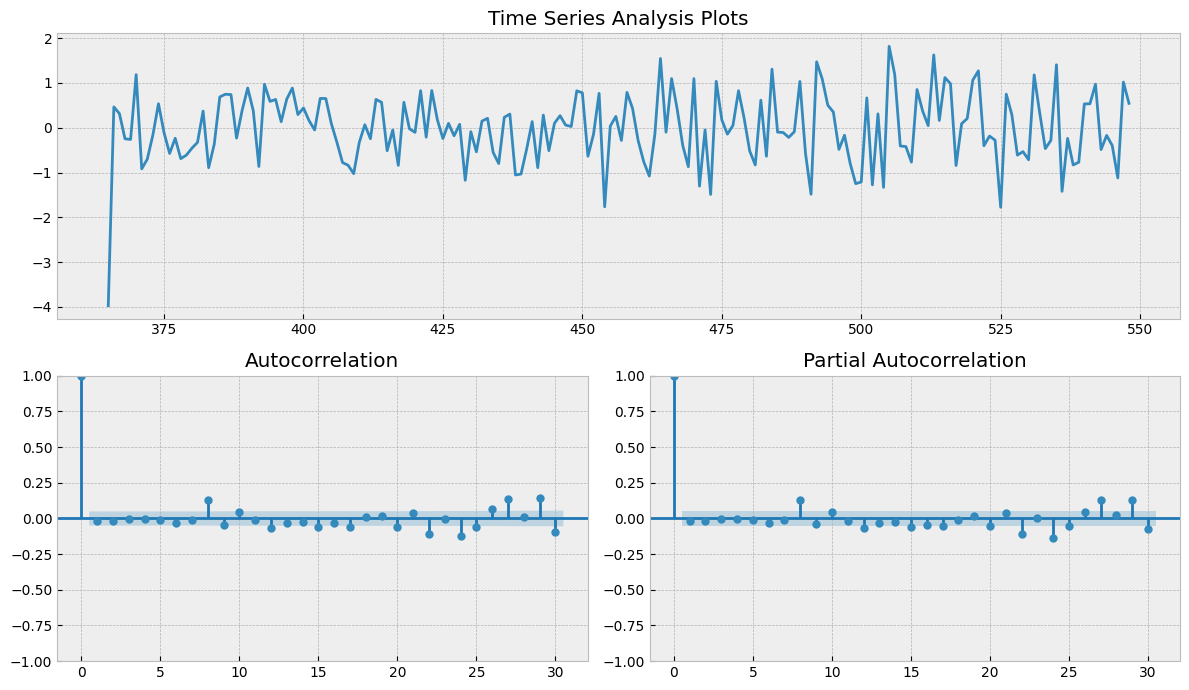

In [ ]:
tsplot(best_model.resid[365:], lags=30)

In [ ]:
df["arima_model_s"] = np.exp(best_model.fittedvalues)
forecast = np.exp(best_model.predict(start = df_train.shape[0], end = df_train.shape[0]+df_test.shape[0]-1))

In [ ]:
# forecast = forecast[:-1]

In [ ]:
nan_indices = df[df['arima_model_s'].isna()].index[:len(forecast)]
df.loc[nan_indices, 'arima_model_s'] = forecast.values
df_test.loc[:, 'arima_model_s'] = forecast.values

<ipython-input-12-cdd014399b21>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:, 'arima_model_s'] = forecast.values


In [ ]:
df['date'] = pd.to_datetime(df['date'], yearfirst=True)

In [ ]:
# df_t_s['date'] = df_t_s['date'].dt.strftime('%Y-%m-%d')

In [ ]:
# type(df_t_s['total_sales'])

pandas.core.series.Series

Root mean squared error: 18935.92875544616
MAPE: % 59.696267962642324
Mean absolute error: 13289.098047459007
Weighted average percentage error: % 46.54557864126126
Root mean squared logarithmic error: 0.5724494638286425


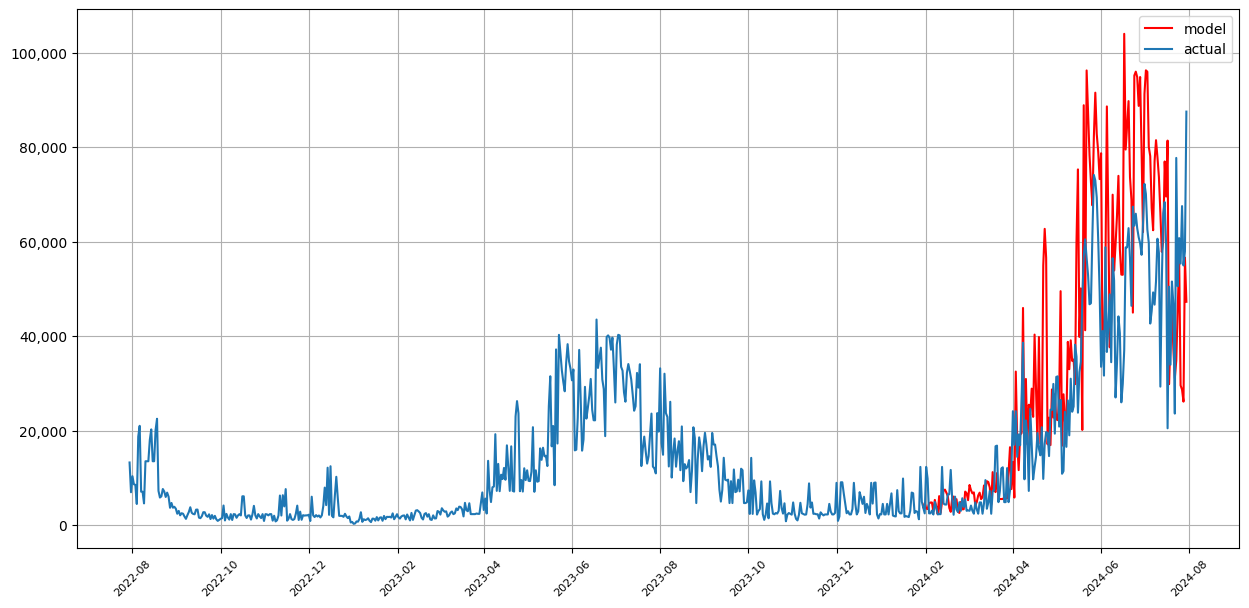

In [ ]:

y_true = df_test.sales_new
y_pred = df_test.arima_model_s
## Подсчёт метрик
rmse = mean_squared_error(y_true, y_pred) ** 0.5
mape = mean_absolute_percentage_error(y_true, y_pred) * 100 ## абсолютный процент ошибки, если много значит плохо
wape = weighted_average_percentage_error(y_true, y_pred) * 100
rmsl = root_mean_squared_logarithmic_error(y_true, y_pred)
print("Root mean squared error:", rmse)
print("MAPE: %", mape)
print('Mean absolute error:', mean_absolute_error(y_true, y_pred))
print('Weighted average percentage error: %', wape)
print('Root mean squared logarithmic error:', rmsl)
##

plt.figure(figsize=(15, 7))
plt.plot(df_test.date, df_test.arima_model_s, color='r', label="model")


plt.plot(df.date,df.sales_new, label="actual")
plt.legend()
# plt.axvspan(len(df), len(forecast), alpha=0.5, color='lightgrey')
plt.grid(True)
# plt.savefig('Colab Notebooks', dpi=300, bbox_inches='tight')

ax = plt.gca()

# Установка формата меток на оси y
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # Устанавливаем шаг в один месяц
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Формат меток: ГГГГ-ММ

# Поворот меток на оси x для лучшей читаемости
plt.xticks(rotation=45)
ax.tick_params(axis='x', labelsize=8)
plt.show()

In [ ]:
df_full_week = df.copy()
df_full_week = df_full_week.groupby(pd.Grouper(key='date', freq='W')).agg({'sales_new': 'sum', 'arima_model_s': 'sum', 'total_sales': 'sum', 'sales': 'sum'}).reset_index()
df_full_week = df_full_week[1:-1]
df_full_week = df_full_week.rename(columns={'date': 'end_week'})
df_full_week

,end_week,sales_new,arima_model_s,total_sales,sales
1,2022-08-07,78632.0000,78515.988336,1359678.00,78632.0
2,2022-08-14,90329.0000,77131.995643,1042644.00,90329.0
3,2022-08-21,88703.2000,102883.481261,942133.00,71856.0
4,2022-08-28,41761.8642,43160.764517,696031.07,0.0
5,2022-09-04,20841.0000,23017.020450,347350.00,0.0
...,...,...,...,...,...
100,2024-06-30,433674.2172,610997.911465,7227903.62,22785.0
101,2024-07-07,401833.7406,571272.328151,6697229.01,4852.0
102,2024-07-14,363230.6672,494182.505973,6571303.18,258475.0
103,2024-07-21,330822.0000,378408.563100,6147150.33,330822.0


In [ ]:
size = int(len(df_full_week) * 0.75)
df_train, df_test = df_full_week[:size], df_full_week[size:]

Root mean squared error: 94641.7954792142
MAPE: % 37.28539944488587
Mean absolute error: 72361.55410885687
Weighted average percentage error: % 37.004782140932285
Root mean squared logarithmic error: 0.35063271733224194


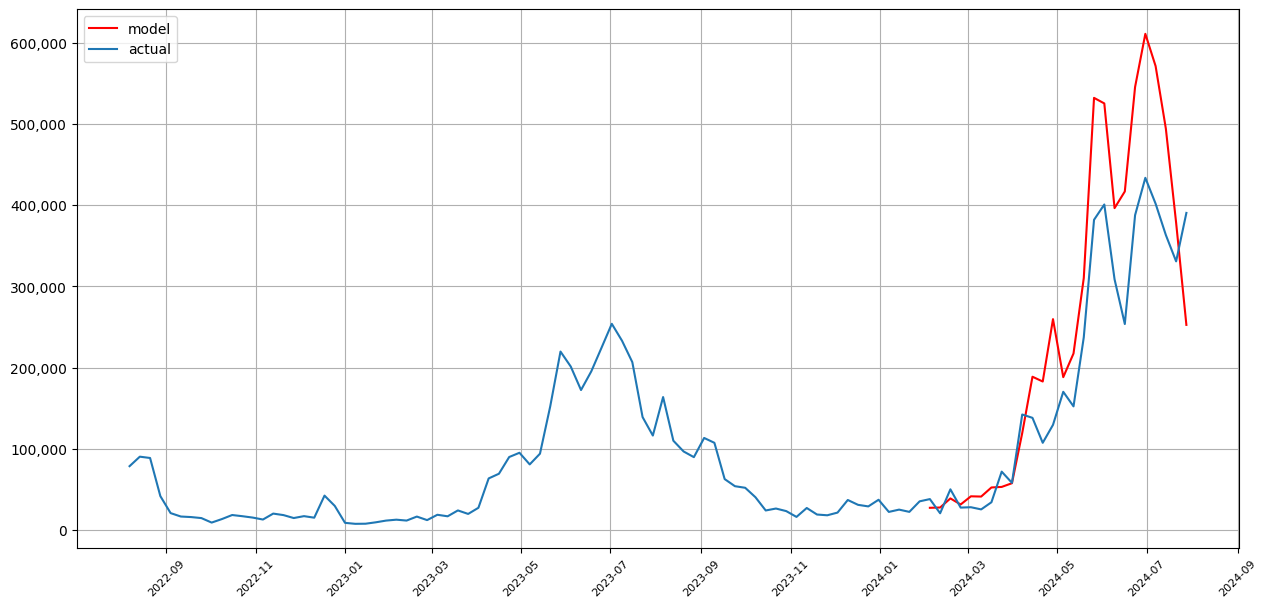

In [ ]:
y_true = df_test.sales_new
y_pred = df_test.arima_model_s
## Подсчёт метрик
rmse = mean_squared_error(y_true, y_pred) ** 0.5
mape = mean_absolute_percentage_error(y_true, y_pred) * 100 ## абсолютный процент ошибки, если много значит плохо
wape = weighted_average_percentage_error(y_true, y_pred) * 100
rmsl = root_mean_squared_logarithmic_error(y_true, y_pred)
print("Root mean squared error:", rmse)
print("MAPE: %", mape)
print('Mean absolute error:', mean_absolute_error(y_true, y_pred))
print('Weighted average percentage error: %', wape)
print('Root mean squared logarithmic error:', rmsl)
##

plt.figure(figsize=(15, 7))
plt.plot(df_test.end_week, df_test.arima_model_s, color='r', label="model")


plt.plot(df_full_week.end_week,df_full_week.sales_new, label="actual")
plt.legend()
# plt.axvspan(len(df), len(forecast), alpha=0.5, color='lightgrey')
plt.grid(True)
# plt.savefig('Colab Notebooks', dpi=300, bbox_inches='tight')

ax = plt.gca()

# Установка формата меток на оси y
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # Устанавливаем шаг в один месяц
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Формат меток: ГГГГ-ММ

# Поворот меток на оси x для лучшей читаемости
plt.xticks(rotation=45)
ax.tick_params(axis='x', labelsize=8)
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_full_week = df_full_week.rename(columns={'arima_model_t_s': 'arima_model_sales_log'})

In [ ]:
df_full_week.to_csv('/content/drive/My Drive/df_SARIMA_sales_log_days_then_week.csv', index=False)